In [3]:
library(ppcor)
library(regclass)
library(tseries)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [35]:
data = read.csv("./Data/num_colos_new.csv")
# the raw data is without diff, need to perform diff for filtering!

In [41]:
data <- read.csv("Data/diff_colos.csv")
data <- data[1:91,-1]

In [42]:
head(data)

,X..arsenic...,X..copper...,X..boron...,X..chloride...,X..molybdenum...,X..vanadium...,X..arsenic....boron..,X..arsenic....molybdenum..,X..arsenic....vanadium..,X..boron....molybdenum..,X..boron....vanadium..,X..molybdenum....vanadium..,X..arsenic....boron....molybdenum..,X..arsenic....boron....vanadium..,X..arsenic....molybdenum....vanadium..,X..boron....molybdenum....vanadium..,X..arsenic....boron....molybdenum....vanadium..
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,5,4,5,0,5,5,5,5,5,5,5,5,5,5,5,5,5
2,-1,0,-2,1,-1,-1,-2,-1,-1,-2,-2,-1,-2,-2,-1,-2,-2
3,-3,-4,-4,-1,-3,-3,-4,-3,-3,-4,-4,-3,-4,-4,-3,-4,-4
4,1,3,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,-3,1,-2,0,0,1,0,0,1,1,0,1,1,0,1,1
6,-1,2,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [43]:
vw = data[,1]

In [44]:
head(vw)

[1]  5 -1 -3  1  0 -1

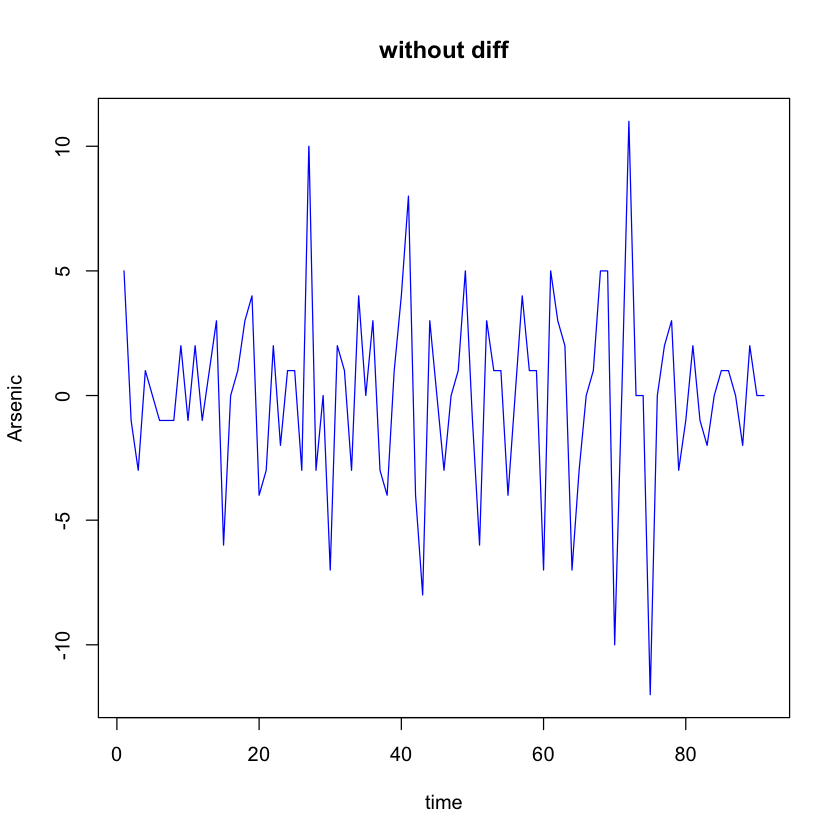

In [45]:
plot(vw,type = "l",ylab = "Arsenic",main = "without diff",col='blue',xlab="time")

pacf = pacf(vw,20)
pacf


Autocorrelations of series ‘vw’, by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.119 -0.337 -0.255  0.087  0.334 -0.157 -0.162  0.007  0.170  0.067 
    11     12     13     14     15     16     17     18     19     20 
-0.164 -0.099  0.185 -0.054  0.064 -0.112  0.075  0.054 -0.149  0.042 

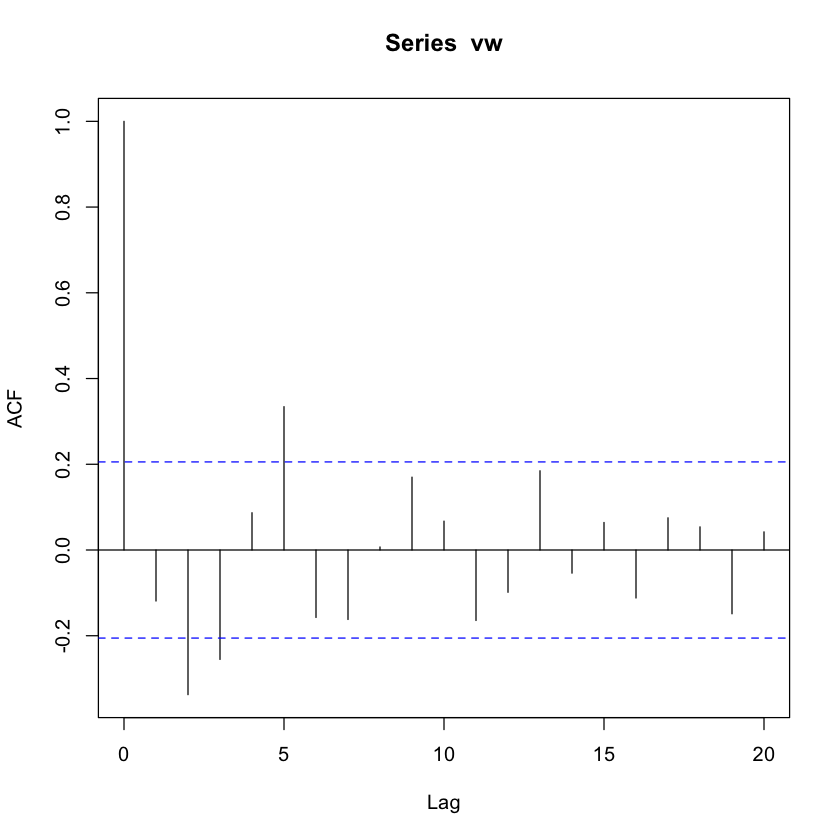

In [46]:
acf = acf(vw,20)
acf

In [47]:
adf.test(vw)


Warning message in adf.test(vw):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  vw
Dickey-Fuller = -5.8828, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


In [11]:
z = diff(vw)

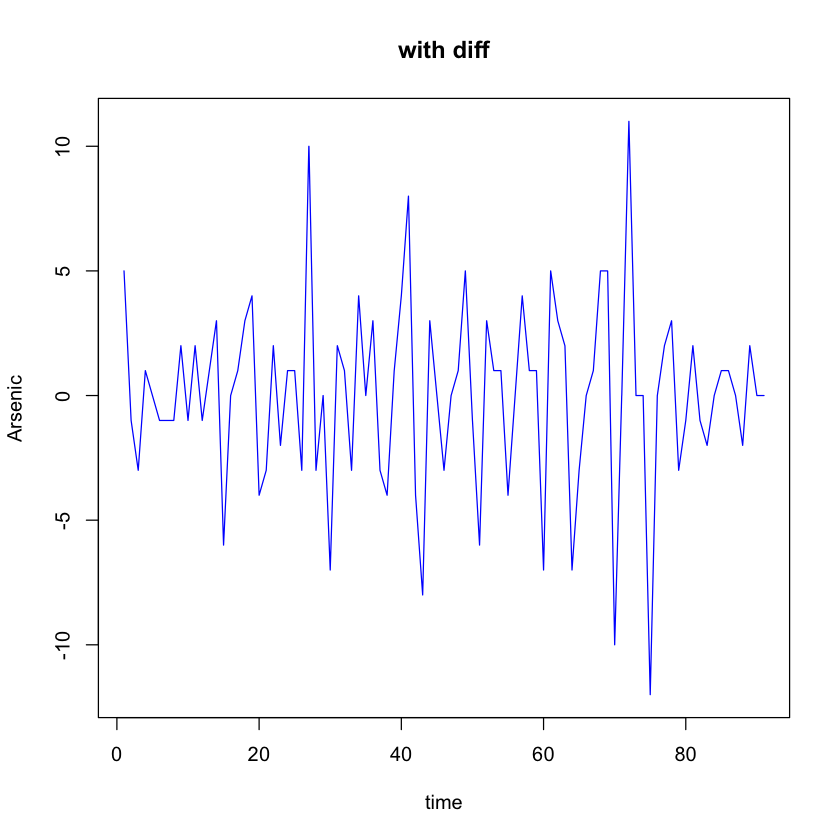

In [48]:
plot(vw,type = "l",ylab = "Arsenic",main="with diff",col='blue',xlab="time")

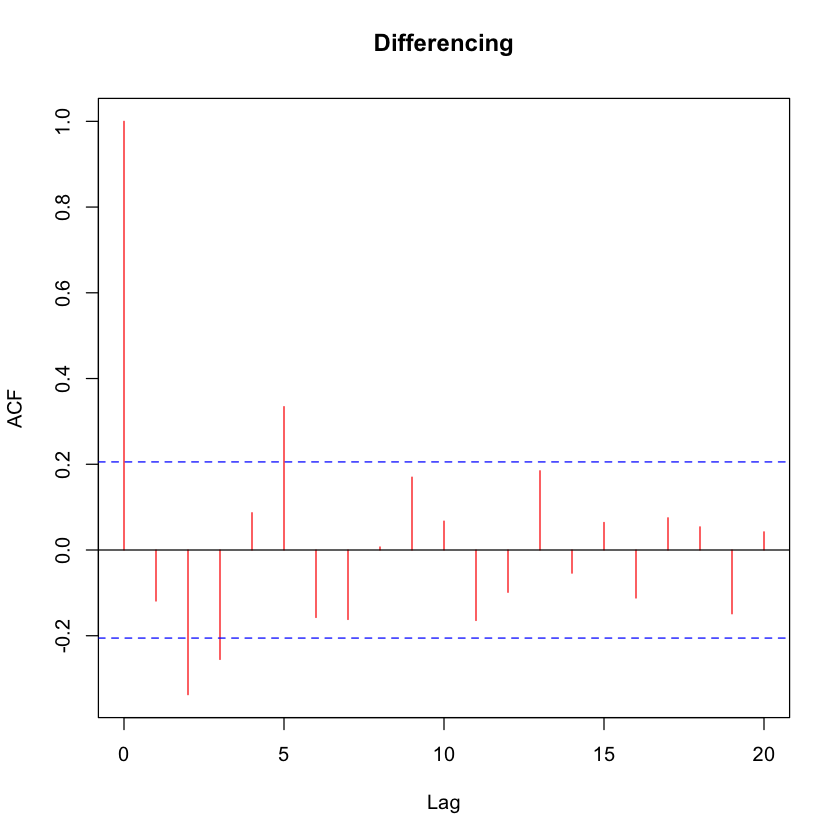

In [52]:
acf(vw,20,main= "Differencing" ,col="red")

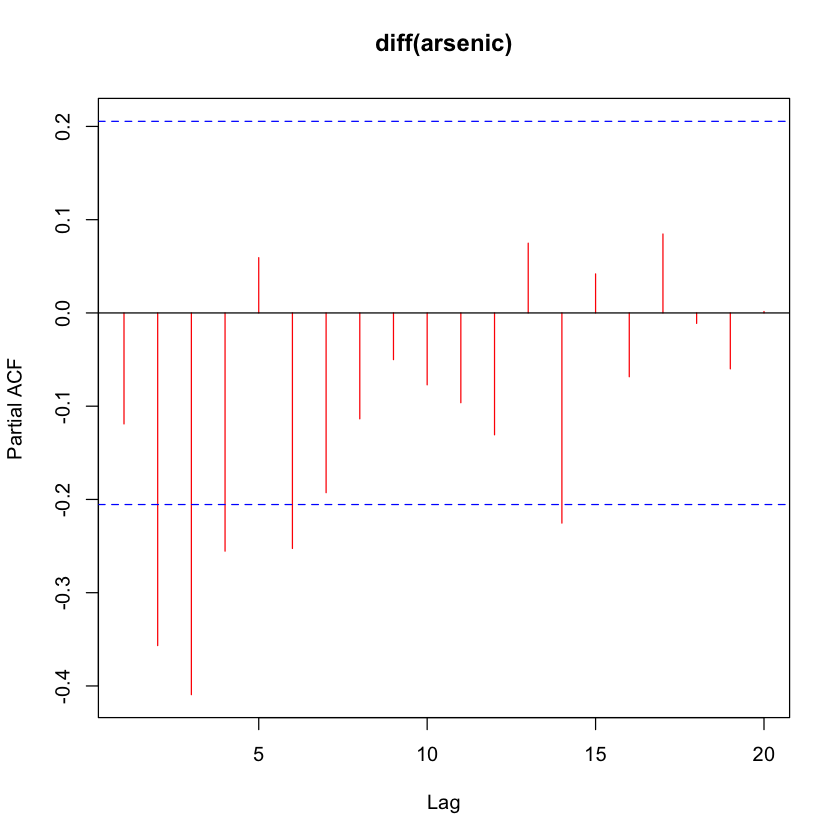

In [53]:
pacf(vw,20,main= "diff(arsenic)",col="red")

In [15]:
adf.test(z)


Warning message in adf.test(z):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  z
Dickey-Fuller = -5.8828, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


In [18]:
adf.test(z)$p.value


Warning message in adf.test(z):
“p-value smaller than printed p-value”


[1] 0.01

In [49]:
m1 <- arima(vw,order = c(4,0,0))
m1


Call:
arima(x = vw, order = c(4, 0, 0))

Coefficients:
          ar1      ar2      ar3      ar4  intercept
      -0.4166  -0.5300  -0.4850  -0.2523    -0.0147
s.e.   0.1019   0.0971   0.0963   0.1004     0.1211

sigma^2 estimated as 9.295:  log likelihood = -231.11,  aic = 474.21

In [50]:
Box.test(m1$residuals,lag=12,type="Ljung")


	Box-Ljung test

data:  m1$residuals
X-squared = 11.765, df = 12, p-value = 0.4648


In [51]:
df <- 12-4
chi <- Box.test(m1$residuals,lag=12,type="Ljung")$statistic
pv=1-pchisq(chi,df) #Compute p-value using 9 degrees of freedom
print(pv)

X-squared 
0.1620125 


In [17]:
names(Box.test(m1$residuals,lag=12,type="Ljung"))

[1] "statistic" "parameter" "p.value"   "method"    "data.name"

In [50]:
names(m1)

[1] "coef"      "sigma2"    "var.coef"  "mask"      "loglik"    "aic"      
 [7] "arma"      "residuals" "call"      "series"    "code"      "n.cond"   
[13] "nobs"      "model"

In [58]:
ll <- lm(data[,2]~data[,3]+0)

In [59]:
summary(ll)


Call:
lm(formula = data[, 2] ~ data[, 3] + 0)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.8673  0.0332  1.0332  2.1244 13.0000 

Coefficients:
          Estimate Std. Error t value Pr(>|t|)    
data[, 3]    1.967      0.153   12.86   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.252 on 91 degrees of freedom
Multiple R-squared:  0.645,	Adjusted R-squared:  0.6411 
F-statistic: 165.3 on 1 and 91 DF,  p-value: < 2.2e-16


In [60]:
names(ll)

[1] "coefficients"  "residuals"     "effects"       "rank"         
 [5] "fitted.values" "assign"        "qr"            "df.residual"  
 [9] "xlevels"       "call"          "terms"         "model"

In [61]:
summary(ll)$r.squared

[1] 0.6449641

In [40]:
# return the R squared value of guo ~ guo_history + yin_history
self_autoregression <- function(x,y,lags){
    n <- length(x)
    x_hist <- x[1:(n-lags)]
    y_hist <- y[1:(n-lags)]
    Y <- y[(lags+1):n]
    m <- lm(Y~x_hist+y_hist+0)
    return (summary(m)$r.squared)
}

# select best time lags
select_time_lags <- function(z,thres = 0.1){
    pacf = pacf(z,20)
    for (i in c(1:20)){
        if (pacf$acf[i]<=thres){
            return (i)
        }
    }
    return (-1)
}

# a helper function to remove an element with certain value from a list
remove <- function(arr,value){
    for(i in c(1:length(arr))){
        if(arr[i]==value){
            r_arr <- arr[-i]
            return (r_arr)
        }
    }
    print("remove failure")
    cat(arr," ",value,"\n")
    return (arr)
}

filter_cause <- function(X,y, thres = 0.1){
    n <- dim(X)[2]
    lags <- c()
    R_squared = c()
    for (i in c(1:n)){
        lag = select_time_lags(X[,i])
        r_sq <- self_autoregression(X[,i],y,lag)
        R_squared = append(R_squared,c(r_sq))
    }

    cause_indices <- c()
    remain <- c(1:n)
    while(length(remain)>0){
        
        j <- which.max(R_squared)
        cause_indices <- append(cause_indices,c(j))
        remain <- remove(remain,j)
        R_squared[j] <- 0
        
        # pruning
        to_remove <- c()
        for(i in remain){
            df <- data.frame(x=X[,j],y=y,z=X[,i])
            pcor <- pcor(df)$estimate[2,3]
            
            if(abs(pcor)<=thres){
                #cat(i," ",pcor,"\n")
                to_remove <- append(to_remove,c(i))
                R_squared[i] <- 0
            }
        }
        for(rm in to_remove){
            remain <- remove(remain,rm)
        }
    }
    return (cause_indices)
}

In [19]:

data <- read.csv("Data/diff_colos.csv")
data <- data[1:91,-1]

In [24]:
data <- data[1:91,-1]

In [25]:
head(data)

,X..arsenic...,X..copper...,X..boron...,X..chloride...,X..molybdenum...,X..vanadium...,X..arsenic....boron..,X..arsenic....molybdenum..,X..arsenic....vanadium..,X..boron....molybdenum..,X..boron....vanadium..,X..molybdenum....vanadium..,X..arsenic....boron....molybdenum..,X..arsenic....boron....vanadium..,X..arsenic....molybdenum....vanadium..,X..boron....molybdenum....vanadium..,X..arsenic....boron....molybdenum....vanadium..
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,5,4,5,0,5,5,5,5,5,5,5,5,5,5,5,5,5
2,-1,0,-2,1,-1,-1,-2,-1,-1,-2,-2,-1,-2,-2,-1,-2,-2
3,-3,-4,-4,-1,-3,-3,-4,-3,-3,-4,-4,-3,-4,-4,-3,-4,-4
4,1,3,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1
5,0,-3,1,-2,0,0,1,0,0,1,1,0,1,1,0,1,1
6,-1,2,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [26]:
dim(data)

[1] 91 17

In [34]:
for (i in 1:17){
#     print(i)
    p <- adf.test(data[1:91,i])$p.value
#     print(p)
    if(p>0.05)
        {print("oh no")}
}

Warning message in adf.test(data[1:91, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:91, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:91, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:91, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:91, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:91, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:91, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:91, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:91, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:91, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:91, i]):
“p-value smaller than printed p-value”
Warning message in adf.test(data[1:91, i]):
“p-value smaller than printed p-value”
Warn

In [46]:
data$X

[1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
[26] 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
[51] 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
[76] 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90

In [58]:
# X <- cbind(data[,4],data[,8],data[,11],data[,12],data[,14],data[,15],data[,17],data[,18])
# y <- data[,10]
# X <- data.frame(X)
X <- read.csv("Data/diff_cause_colos.csv")
X <- X[1:91,-1]

In [59]:
names(X) <- c("(B)","(As,B)","(B,Mo)","(B,V)","(As,B,Mo)","(As,B,V)","(B,Mo,V)","(As,B,Mo,V)","(As)")
# X$Y <- y

In [60]:
head(X)

,(B),"(As,B)","(B,Mo)","(B,V)","(As,B,Mo)","(As,B,V)","(B,Mo,V)","(As,B,Mo,V)",(As)
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,5,5,5,5,5,5,5,5,5
2,-2,-2,-2,-2,-2,-2,-2,-2,-1
3,-4,-4,-4,-4,-4,-4,-4,-4,-3
4,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,0
6,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [59]:
mod1 <- lm(Y~.,data=X)
VIF(mod1)

ERROR: Error in VIF(mod1): there are aliased coefficients in the model


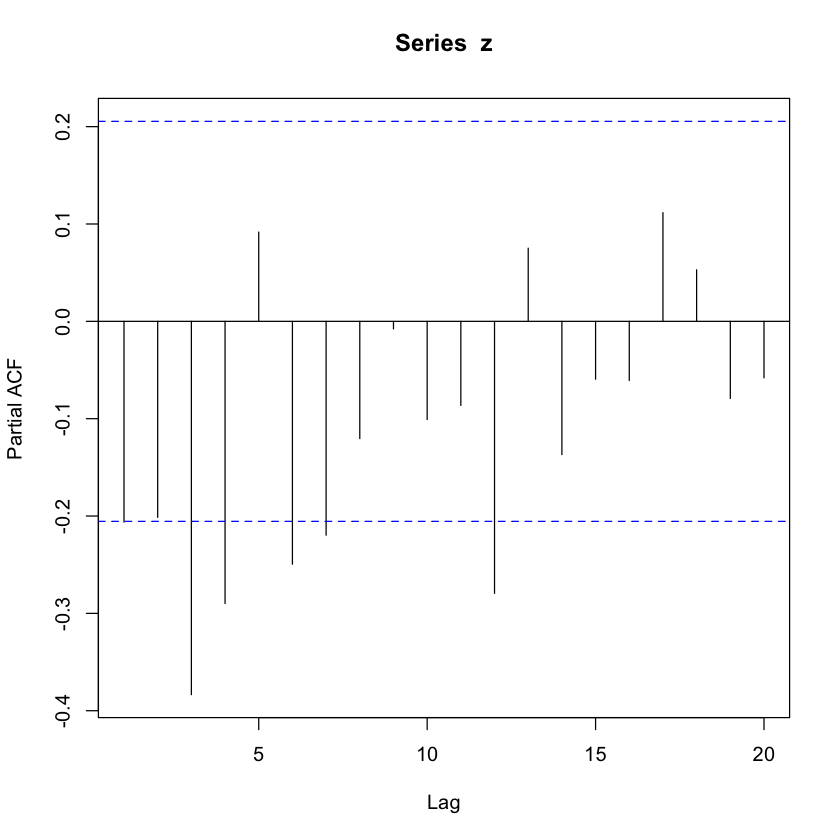

Warning message in pcor(df):
“The inverse of variance-covariance matrix is calculated using Moore-Penrose generalized matrix invers due to its determinant of zero.”
Warning message in sqrt((n - 2 - gp)/(1 - pcor^2)):
“NaNs produced”
Warning message in pcor(df):
“The inverse of variance-covariance matrix is calculated using Moore-Penrose generalized matrix invers due to its determinant of zero.”
Warning message in sqrt((n - 2 - gp)/(1 - pcor^2)):
“NaNs produced”
Warning message in pcor(df):
“The inverse of variance-covariance matrix is calculated using Moore-Penrose generalized matrix invers due to its determinant of zero.”
Warning message in sqrt((n - 2 - gp)/(1 - pcor^2)):
“NaNs produced”
Warning message in pcor(df):
“The inverse of variance-covariance matrix is calculated using Moore-Penrose generalized matrix invers due to its determinant of zero.”
Warning message in sqrt((n - 2 - gp)/(1 - pcor^2)):
“NaNs produced”
Warning message in pcor(df):
“The inverse of variance-covariance mat

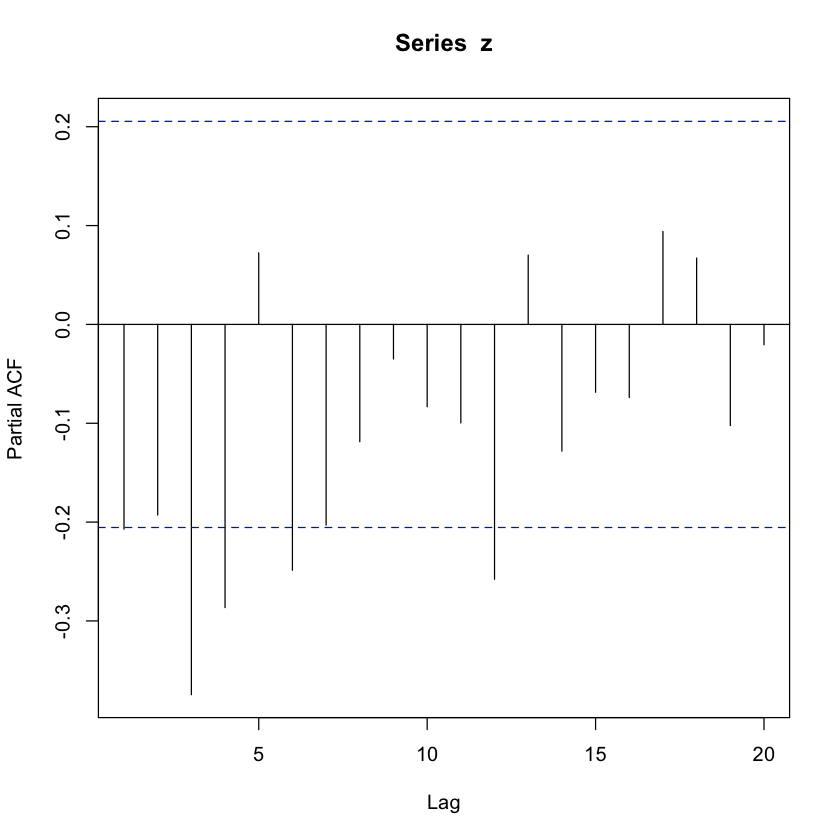

In [62]:
# X is a dataframe contatianing causes, y is cause
# first test 
# y=arsenic, index = 2
# X = boran, sulfate; index = 4,5. And turn to be 1,2 in new df
# X <- cbind(data[,4],data[,8],data[,11],data[,12],data[,14],data[,15],data[,17],data[,18])
# y <- data[,10]
direct <- filter_cause(X[1:91,-9],X[1:91,9])

In [63]:
direct

[1] 2 3 4 5 6 7 8 1

In [150]:
arr <- c(1,2,3,4,5,6)

In [153]:
t <- remove(t,2)
t

[1] 1 3 6

In [179]:
for (i in direct) print(direct[i])

[1] 6
[1] 2
[1] 3
[1] 1
[1] 5
[1] 4


In [205]:
dim(data)

[1] 91 16